In [31]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline  

import seaborn as sns 

import statsmodels.api as sm
import statsmodels.formula.api as smf


import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn import linear_model
from sklearn.model_selection import train_test_split 

import scipy.stats as stats

import math 

In [4]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
# Scrub - Converting data types 

In [6]:
#convert column name ['date'] from object to datetime 

#might be cool to create a function that takes any column date and converts it 

df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11), object(1)
memory 

In [7]:
# Obvious issue with sqft_basement due to columns
#First attempt to convert failed due to ? marks so we need to remove them 

df['sqft_basement'].nunique() 

304

In [8]:
#replacing all ? with 0's - major assumption that requires data enrichment to correct
#

df['sqft_basement'] = df['sqft_basement'].map(lambda x: 0 if x==
                                             '?' else x)

df['sqft_basement'] = df['sqft_basement'].astype(float)

In [9]:
# Scrub - Treating Null values 

In [10]:
# Identify null values 

df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [11]:
# Look for columns where all 3 are missing 
#This isnt a huge % of the data so we allow it 

print('Number Missing All Three:',
     len(df[(df.waterfront.isnull())
           & (df.view.isnull())
           & (df.yr_renovated.isnull())]))

Number Missing All Three: 2


In [12]:
#Repeat the same process for view which indicates how many times a house has been viewed

#We replaced all views with a median value, its safe to assume houses on the market in these areas are quite popular and viewed 
median = df['view'].median()
df['view'] = df['view'].fillna(value=median)#Waterfront 0 = No waterfront, 1=Waterfront 

#Making all nulls 0 indicating no waterfront 

df['waterfront'].isna().sum()

df['waterfront'] = df['waterfront'].fillna(0)

In [13]:
# Assuming renovation nulls are the same as renovation yr_built 

df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [14]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# Major assumptions of scrubbing 

1. Waterfront - nulls = 0 and 1 means on the waterfront, replaced all nulls with 0 

2. Filled view with median value, assuming all houses are viewed or in demand (justification is this is a major area with lots of people moving there) 

3. if there is no yr_renovated, fill with most recent year built 

In [15]:
#dropped all duplicates for id 
#inplace = True changes the dataframe permanently

df.drop_duplicates(subset=['id'], inplace=True)

# Scrubbing - Outliers 

# Exploring Categorical & Numerical Variables 

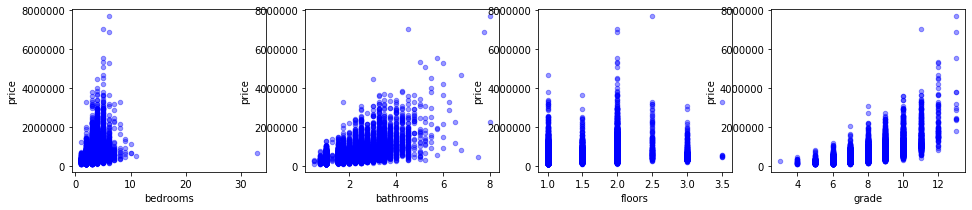

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 'bathrooms', 'floors', 'grade'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

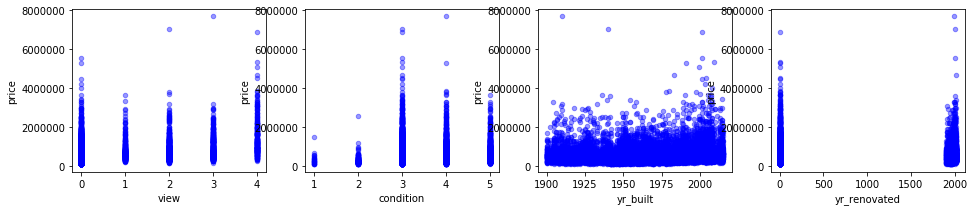

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['view', 'condition', 'yr_built', 'yr_renovated'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

# Checking for Linear Relationships to find the best data
## Comment/uncomment cell below for outlier removal code 

In [18]:
#sqft_living 

indexNames = df[df['sqft_living'] >= 5000 ].index
df.drop(indexNames , inplace=True)

# sqft_above 

indexNames = df[df['sqft_above'] >= 4500 ].index
df.drop(indexNames , inplace=True)

#sqft_basement 

indexNames = df[df['sqft_basement'] >= 2000 ].index
df.drop(indexNames , inplace=True)

# dropping sqft_lot outliers

indexNames = df[df['sqft_lot'] >= 100000 ].index
df.drop(indexNames , inplace=True)

# dropping sqft_living15 outliers

indexNames = df[df['sqft_living15'] >= 4500 ].index
df.drop(indexNames , inplace=True)


# dropping sqft_lot15 outliers

indexNames = df[df['sqft_lot15'] >= 100000 ].index
df.drop(indexNames , inplace=True)


# dropping grade outliers
indexNames = df[df['grade'] == 3 ].index
df.drop(indexNames , inplace=True)

indexNames = df[df['grade'] == 13 ].index
df.drop(indexNames , inplace=True)

# dropping bedroom outliers over 8 rooms
indexNames = df[df['bedrooms'] >= 8 ].index
df.drop(indexNames , inplace=True)

#drop houses over a million
indexNames = df[df['price'] >= 1000000].index
df.drop(indexNames, inplace=True)

In [71]:
df = df.drop(df['id', 'date'], inplace=True)

KeyError: ('id', 'date')

In [20]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [26]:
x = pd.DataFrame(df[['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 
     'sqft_basement',
       'sqft_living15']])
y = pd.DataFrame(df['price'])
y.head()

,price
0,221900.0
1,538000.0
2,180000.0
3,604000.0
4,510000.0


In [28]:
x.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_basement,sqft_living15
count,19394.000000,19394.000000,19394.000000,19394.000000,19394.000000,19394.000000,19394.000000
mean,3.314169,2.030435,1934.837011,9811.660204,1.471821,254.289058,1897.099722
std,0.865549,0.692493,728.711322,10606.555760,0.538104,393.426251,594.008619
min,1.000000,0.500000,370.000000,520.000000,1.000000,0.000000,460.000000
25%,3.000000,1.500000,1390.000000,5000.000000,1.000000,0.000000,1460.000000
50%,3.000000,2.000000,1830.000000,7390.000000,1.000000,0.000000,1780.000000
75%,4.000000,2.500000,2390.000000,9990.000000,2.000000,500.000000,2240.000000
max,7.000000,5.750000,4940.000000,99916.000000,3.500000,1990.000000,4495.000000


In [32]:
reg=linear_model.LinearRegression()

In [33]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=4)

In [34]:
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
reg.coef_ #weights of each coefficent, their  

array([[-2.12805284e+04, -6.89662899e+03,  1.13442079e+02,
        -1.18723243e+00,  3.77017711e+04,  5.02076243e+01,
         8.45834582e+01]])

In [39]:
pred = reg.predict(x_test) #make predictions

In [56]:
pred[[1, 5, 10]] #see predictions

array([[385453.96608603],
       [514898.50910616],
       [496966.5379404 ]])

In [61]:
y_test.iloc[[1,5,10]]

,price
4871,498800.0
2053,349000.0
8140,477500.0


In [62]:
# mean squared error

np.mean((pred-y_test)**2)

price    2.199169e+10
dtype: float64

In [65]:
# root mean squared error

np.sqrt(((pred-y_test)**2).mean())

price    148295.94044
dtype: float64

In [ ]:
# Redo the P value Test 

In [66]:
x2 = sm.add_constant(x)

C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [67]:
est=sm.OLS(y, x2)

In [68]:
est2=est.fit()

In [69]:
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     1861.
Date:                Tue, 18 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:36:17   Log-Likelihood:            -2.5873e+05
No. Observations:               19394   AIC:                         5.175e+05
Df Residuals:                   19386   BIC:                         5.175e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.105e+05   5604.201     19.711

In [82]:
x = pd.DataFrame(df[['sqft_lot', 'floors', 'sqft_living', 'bathrooms', 'bedrooms']])
y = pd.DataFrame(df['price'])

In [83]:
reg=linear_model.LinearRegression()

In [84]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=4)

reg.fit(x_train, y_train)

pred = reg.predict(x_test) #make predictions

x2 = sm.add_constant(x)

est=sm.OLS(y, x2)

est2=est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     2300.
Date:                Tue, 18 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:43:54   Log-Likelihood:            -2.5920e+05
No. Observations:               19394   AIC:                         5.184e+05
Df Residuals:                   19388   BIC:                         5.185e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.886e+05   5124.711     36.807      

C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [87]:
dummies = pd.get_dummies(df.grade)
dummies.columns

Int64Index([4, 5, 6, 7, 8, 9, 10, 11], dtype='int64')

In [143]:
dummies[4] = dummies[4].astype("category")
dummies[5] = dummies[5].astype("category")
dummies[6] = dummies[6].astype("category")
dummies[7] = dummies[7].astype("category")
dummies[8] = dummies[8].astype("category")
dummies[9] = dummies[9].astype("category")
dummies[10] = dummies[10].astype("category")
dummies[11] = dummies[11].astype("category")

In [144]:
dummies.dtypes

4     category
5     category
6     category
7     category
8     category
9     category
10    category
11    category
dtype: object

In [145]:
price =  df['price']

In [146]:
merged_grade = pd.concat([price, dummies], axis='columns')

In [158]:
merged_grade.head()

,price,4,5,6,7,8,9,10,11
0,221900.0,0,0,0,1,0,0,0,0
1,538000.0,0,0,0,1,0,0,0,0
2,180000.0,0,0,1,0,0,0,0,0
3,604000.0,0,0,0,1,0,0,0,0
4,510000.0,0,0,0,0,1,0,0,0


In [159]:
merged_grade.columns

Index(['price', '4', '5', '6', '7', '8', '9', '10', '11'], dtype='object')

In [160]:
merged_grade.columns = merged_grade.columns.astype(str)

In [161]:
merged_grade.columns

Index(['price', '4', '5', '6', '7', '8', '9', '10', '11'], dtype='object')

In [151]:
from statsmodels.formula.api import ols

In [156]:
outcome ='price'
x_cols = ['4', '5', '6', '7', '8', '9', '10', '11']

In [162]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=merged_grade).fit()
model.summary()

PatsyError: numbers besides '0' and '1' are only allowed with **
    price~4+5+6+7+8+9+10+11
          ^

In [39]:
merged_grade = pd.concat([df, dummies], axis='columns')

In [83]:
merged_grade.dtypes

price    float64
4          uint8
5          uint8
6          uint8
7          uint8
8          uint8
9          uint8
10         uint8
11         uint8
dtype: object

In [40]:
merged_grade.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_living15,sqft_lot15,4,5,6,7,8,9,10,11
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,...,1340,5650,0,0,0,1,0,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,1690,7639,0,0,0,1,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,...,2720,8062,0,0,1,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,1360,5000,0,0,0,1,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,...,1800,7503,0,0,0,0,1,0,0,0


In [ ]:
# Some brief preprocessing
merged_grade.columns = [col.replace(' ', '_') for col in merged_grade.columns]
for col in x_cols:
    merged_grade[col] = ([col] - df[col].mean())/df[col].std()
df.head()

In [70]:
merged_grade

,price,4,5,6,7,8,9,10,11
0,221900.0,0,0,0,1,0,0,0,0
1,538000.0,0,0,0,1,0,0,0,0
2,180000.0,0,0,1,0,0,0,0,0
3,604000.0,0,0,0,1,0,0,0,0
4,510000.0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
21592,360000.0,0,0,0,0,1,0,0,0
21593,400000.0,0,0,0,0,1,0,0,0
21594,402101.0,0,0,0,1,0,0,0,0
21595,400000.0,0,0,0,0,1,0,0,0


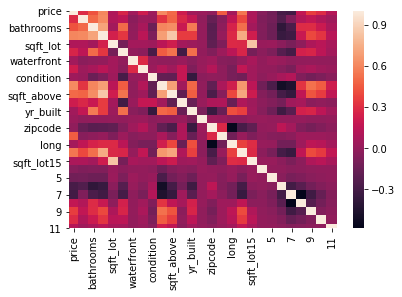

In [42]:
corr = merged_grade.corr()

sns.heatmap(corr)

In [45]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [51]:
X = merged_grade.drop(['price', 'grade'], axis='columns')
X

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,...,sqft_living15,sqft_lot15,4,5,6,7,8,9,10,11
0,3,1.00,1180,5650,1.0,0.0,0.0,3,1180,0.0,...,1340,5650,0,0,0,1,0,0,0,0
1,3,2.25,2570,7242,2.0,0.0,0.0,3,2170,400.0,...,1690,7639,0,0,0,1,0,0,0,0
2,2,1.00,770,10000,1.0,0.0,0.0,3,770,0.0,...,2720,8062,0,0,1,0,0,0,0,0
3,4,3.00,1960,5000,1.0,0.0,0.0,5,1050,910.0,...,1360,5000,0,0,0,1,0,0,0,0
4,3,2.00,1680,8080,1.0,0.0,0.0,3,1680,0.0,...,1800,7503,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,1131,3.0,0.0,0.0,3,1530,0.0,...,1530,1509,0,0,0,0,1,0,0,0
21593,4,2.50,2310,5813,2.0,0.0,0.0,3,2310,0.0,...,1830,7200,0,0,0,0,1,0,0,0
21594,2,0.75,1020,1350,2.0,0.0,0.0,3,1020,0.0,...,1020,2007,0,0,0,1,0,0,0,0
21595,3,2.50,1600,2388,2.0,0.0,0.0,3,1600,0.0,...,1410,1287,0,0,0,0,1,0,0,0


In [53]:
y = merged_grade.price
y

0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21592    360000.0
21593    400000.0
21594    402101.0
21595    400000.0
21596    325000.0
Name: price, Length: 19394, dtype: float64

In [59]:
model = model.fit(X, y)

In [60]:
model.score(X,y)

0.6953589365813527

AttributeError: 'LinearRegression' object has no attribute 'summary'

In [105]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

In [110]:
categorical_columns = ['waterfront', 'view', 'condition', 'grade']

numerical_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot',  'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']

column_trans = make_column_transformer((categorical_columns, OneHotEncoder(handle_unknown='ignore'), (numerical_columns, RobustScaler())

column_trans.fit_transform(df)

SyntaxError: invalid syntax (<ipython-input-110-cf292ab3bd3c>, line 8)

In [108]:
X.head()

,waterfront,view,condition,grade
0,0.0,0.0,3,7
1,0.0,0.0,3,7
2,0.0,0.0,3,6
3,0.0,0.0,5,7
4,0.0,0.0,3,8


In [ ]:
df = pd.concat()

In [43]:
# OLS Regression

In [44]:
# OLS Regression

#It didnt seem to work!

import statsmodels.api as sm
import statsmodels.formula.api as smf

col_names = df_combo.describe().columns[1:11] #What does this?

results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p_value ']] #creating an array of results we care about

for idx, val in enumerate(col_names):
    print('price~' + val)
    f = 'price~' + val
    model = smf.ols(formula=f, data=df_combo).fit()
    X_new = pd.DataFrame({val: [df_combo[val].min(), df_combo[val].max()]});
    preds = model.predict(X_new)
    results.append({val, model.rsquared, model.params[0], model.params[1], model.pvalues[1]})

    print(results[idx+1])
    print(model.summary())

price~bedrooms
{0.08183418312055257, 0.0, 'bedrooms', 199828.7774547661, 232191.78778389437}
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     1728.
Date:                Sat, 15 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:36:17   Log-Likelihood:            -2.6289e+05
No. Observations:               19394   AIC:                         5.258e+05
Df Residuals:                   19392   BIC:                         5.258e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

{0.046469500340906245, 1.1278606624760168e-202, 106.6324946852408, 437228.7829403785, 'sqft_basement'}
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     945.1
Date:                Sat, 15 Feb 2020   Prob (F-statistic):          1.13e-202
Time:                        20:36:17   Log-Likelihood:            -2.6325e+05
No. Observations:               19394   AIC:                         5.265e+05
Df Residuals:                   19392   BIC:                         5.265e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [47]:
# Non encoded, assumptions of regression not met in regression below 

outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'sqft_living15', 'sqft_lot15']

In [48]:
# Some brief preprocessing
df.columns = [col.replace(' ', '_') for col in df.columns]
for col in x_cols:
    df[col] = (df[col] - df[col].mean())/df[col].std()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,-0.362971,-1.488007,-1.035852,-0.392367,-0.876822,-0.048758,-0.255718,...,-0.496007,-0.714531,-0.646345,-0.535146,-0.512471,98178,47.5112,-122.257,-0.937865,-0.384713
1,6414100192,2014-12-09,538000.0,-0.362971,0.317065,0.871625,-0.242271,0.981556,-0.048758,-0.255718,...,-0.496007,0.714725,0.370364,-0.672068,1.972214,98125,47.7210,-122.319,-0.348648,-0.169955
2,5631500400,2015-02-25,180000.0,-1.518307,-1.488007,-1.598489,0.017757,-0.876822,-0.048758,-0.255718,...,-1.500766,-1.306445,-0.646345,-1.288215,1.899832,98028,47.7379,-122.233,1.385334,-0.124283
3,2487200875,2014-12-09,604000.0,0.792365,1.400108,0.034531,-0.453650,-0.876822,-0.048758,-0.255718,...,-0.496007,-0.902211,1.666668,-0.192842,-0.512471,98136,47.5208,-122.393,-0.904195,-0.454895
4,1954400510,2015-02-18,510000.0,-0.362971,-0.043949,-0.349709,-0.163263,-0.876822,-0.048758,-0.255718,...,0.508752,0.007316,-0.646345,0.560227,-0.512471,98074,47.6168,-122.045,-0.163465,-0.184640


In [49]:
from statsmodels.formula.api import ols

In [50]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     1664.
Date:                Sat, 15 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:36:17   Log-Likelihood:            -2.5569e+05
No. Observations:               19394   AIC:                         5.114e+05
Df Residuals:                   19378   BIC:                         5.115e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.643e+05    924.147    502.457      0.000    4.63e+05    4.66e+05
bedrooms       -1.36e+04   1216.365    -11.180      0.000    -1.6e+04   -1.12e+04
bathrooms      1.752e+04   1585.070     11.053      0.000    1.44e+04    2.06e+04
sqft_living    5.256e+04   9598.333      5.476      0.000    3.37e+04    7.14e+04
sqft_lot        271.3396   1690.345      0.161      0.872   -3041.883    3584.563
floors         2.642e+04   1337.514     19.753      0.000    2.38e+04     2.9e+04
waterfront     5699.7366    970.925      5.870      0.000    3796.640    7602.834
view           1.062e+04   1007.081     10.543      0.000    8643.847    1.26e+04
condition      1.192e+04   1010.765     11.789      0.000    9934.705    1.39e+04
grade           8.87e+04   1484.597     59.745      0.000    8.58e+04    9.16e+04
sqft_above    -1.175e+04   9091.320     -1.292      0.196   -2.96e+04    6073.419
sqft_basement  5806.8854   5128.023      1.132      0.257   -4244.482    1.59e+04
yr_built      -7.535e+04   1298.075    -58.048      0.000   -7.79e+04   -7.28e+04
yr_renovated    928.7505    931.753      0.997      0.319    -897.565    2755.066
sqft_living15  3.595e+04   1534.457     23.426      0.000    3.29e+04     3.9e+04
sqft_lot15    -1.143e+04   1690.401     -6.764      0.000   -1.47e+04   -8121.025
==============================================================================
Omnibus:                      401.867   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              474.942
Skew:                           0.301   Prob(JB):                    7.37e-104
Kurtosis:                       3.475   Cond. No.                         33.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
# Same as above but removed yr_renovated','sqft_basement', 

outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'sqft_living',
       
        'floors', 'view', 'condition', 'grade',
       'yr_built', 
       'sqft_living15', 'sqft_lot15']

cols_removed = ['sqft_above', 'sqft_living15', 'waterfront']

In [84]:
# Some brief preprocessing
df.columns = [col.replace(' ', '_') for col in df.columns]
for col in x_cols:
    df[col] = (df[col] - df[col].mean())/df[col].std()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,-0.362971,-1.488007,-1.035852,-0.392367,-0.876822,-0.048758,-0.255718,...,-0.496007,-0.714531,-0.646345,-0.535146,-0.512471,98178,47.5112,-122.257,-0.937865,-0.384713
1,6414100192,2014-12-09,538000.0,-0.362971,0.317065,0.871625,-0.242271,0.981556,-0.048758,-0.255718,...,-0.496007,0.714725,0.370364,-0.672068,1.972214,98125,47.7210,-122.319,-0.348648,-0.169955
2,5631500400,2015-02-25,180000.0,-1.518307,-1.488007,-1.598489,0.017757,-0.876822,-0.048758,-0.255718,...,-1.500766,-1.306445,-0.646345,-1.288215,1.899832,98028,47.7379,-122.233,1.385334,-0.124283
3,2487200875,2014-12-09,604000.0,0.792365,1.400108,0.034531,-0.453650,-0.876822,-0.048758,-0.255718,...,-0.496007,-0.902211,1.666668,-0.192842,-0.512471,98136,47.5208,-122.393,-0.904195,-0.454895
4,1954400510,2015-02-18,510000.0,-0.362971,-0.043949,-0.349709,-0.163263,-0.876822,-0.048758,-0.255718,...,0.508752,0.007316,-0.646345,0.560227,-0.512471,98074,47.6168,-122.045,-0.163465,-0.184640


In [85]:
from statsmodels.formula.api import ols

In [86]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     2467.
Date:                Sat, 15 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:37:37   Log-Likelihood:            -2.5575e+05
No. Observations:               19394   AIC:                         5.115e+05
Df Residuals:                   19383   BIC:                         5.116e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.643e+05    927.235    500.784      0.000    4.63e+05    4.66e+05
bedrooms        -1.4e+04   1219.506    -11.476      0.000   -1.64e+04   -1.16e+04
bathrooms      2.058e+04   1558.890     13.204      0.000    1.75e+04    2.36e+04
sqft_living    4.855e+04   1924.441     25.227      0.000    4.48e+04    5.23e+04
floors         2.065e+04   1196.335     17.265      0.000    1.83e+04     2.3e+04
view           1.373e+04    956.590     14.351      0.000    1.19e+04    1.56e+04
condition      1.238e+04   1010.382     12.253      0.000    1.04e+04    1.44e+04
grade           8.74e+04   1484.786     58.862      0.000    8.45e+04    9.03e+04
yr_built      -7.681e+04   1287.171    -59.676      0.000   -7.93e+04   -7.43e+04
sqft_living15   3.23e+04   1500.032     21.533      0.000    2.94e+04    3.52e+04
sqft_lot15    -1.177e+04    994.070    -11.836      0.000   -1.37e+04   -9817.752
==============================================================================
Omnibus:                      384.866   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              446.481
Skew:                           0.299   Prob(JB):                     1.12e-97
Kurtosis:                       3.441   Cond. No.                         4.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_combo).fit()
model.summary()

In [91]:
outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'sqft_living',
       
        'floors', 'view', 'condition', 'grade',
       'yr_built', 
       'sqft_living15', 'sqft_lot15']


In [92]:
# Some brief preprocessing
df.columns = [col.replace(' ', '_') for col in df.columns]
for col in x_cols:
    df[col] = (df[col] - df[col].mean())/df[col].std()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,-0.362971,-1.488007,-1.035852,-0.392367,-0.876822,-0.048758,-0.255718,...,-0.496007,-0.714531,-0.646345,-0.535146,-0.512471,98178,47.5112,-122.257,-0.937865,-0.384713
1,6414100192,2014-12-09,538000.0,-0.362971,0.317065,0.871625,-0.242271,0.981556,-0.048758,-0.255718,...,-0.496007,0.714725,0.370364,-0.672068,1.972214,98125,47.7210,-122.319,-0.348648,-0.169955
2,5631500400,2015-02-25,180000.0,-1.518307,-1.488007,-1.598489,0.017757,-0.876822,-0.048758,-0.255718,...,-1.500766,-1.306445,-0.646345,-1.288215,1.899832,98028,47.7379,-122.233,1.385334,-0.124283
3,2487200875,2014-12-09,604000.0,0.792365,1.400108,0.034531,-0.453650,-0.876822,-0.048758,-0.255718,...,-0.496007,-0.902211,1.666668,-0.192842,-0.512471,98136,47.5208,-122.393,-0.904195,-0.454895
4,1954400510,2015-02-18,510000.0,-0.362971,-0.043949,-0.349709,-0.163263,-0.876822,-0.048758,-0.255718,...,0.508752,0.007316,-0.646345,0.560227,-0.512471,98074,47.6168,-122.045,-0.163465,-0.184640


In [93]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     2467.
Date:                Sat, 15 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:38:13   Log-Likelihood:            -2.5575e+05
No. Observations:               19394   AIC:                         5.115e+05
Df Residuals:                   19383   BIC:                         5.116e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.643e+05    927.235    500.784      0.000    4.63e+05    4.66e+05
bedrooms        -1.4e+04   1219.506    -11.476      0.000   -1.64e+04   -1.16e+04
bathrooms      2.058e+04   1558.890     13.204      0.000    1.75e+04    2.36e+04
sqft_living    4.855e+04   1924.441     25.227      0.000    4.48e+04    5.23e+04
floors         2.065e+04   1196.335     17.265      0.000    1.83e+04     2.3e+04
view           1.373e+04    956.590     14.351      0.000    1.19e+04    1.56e+04
condition      1.238e+04   1010.382     12.253      0.000    1.04e+04    1.44e+04
grade           8.74e+04   1484.786     58.862      0.000    8.45e+04    9.03e+04
yr_built      -7.681e+04   1287.171    -59.676      0.000   -7.93e+04   -7.43e+04
sqft_living15   3.23e+04   1500.032     21.533      0.000    2.94e+04    3.52e+04
sqft_lot15    -1.177e+04    994.070    -11.836      0.000   -1.37e+04   -9817.752
==============================================================================
Omnibus:                      384.866   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              446.481
Skew:                           0.299   Prob(JB):                     1.12e-97
Kurtosis:                       3.441   Cond. No.                         4.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Regression model Validation

In [110]:
y = df['price']

X = df[['bedrooms', 'bathrooms', 'sqft_living',
       
        'floors', 'view', 'condition', 'grade',
       'yr_built', 
       'sqft_living15', 'sqft_lot15']]



# Perform a Train-Test Split

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [113]:
# A brief preview of our train test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

14545 4849 14545 4849


# Apply your model to the train set 

In [114]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [115]:
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [116]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# Calculate predictions on training and test sets 

In [117]:
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [118]:
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [119]:
y_hat_test

array([417921.19553166, 765526.13007805, 602855.85187968, ...,
       590341.01097497, 342511.39925159, 442205.57553117])

# Calculate training and test residuals 

In [120]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

# Calculate Mean Squared Error

In [121]:
from sklearn.metrics import mean_squared_error

In [122]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 16703351970.352978
Test Mean Squarred Error: 16557647309.79753


In [140]:
import math 

print(math.sqrt(test_mse))

127728.03222027721


# Evaluate the effect of train-test split size 

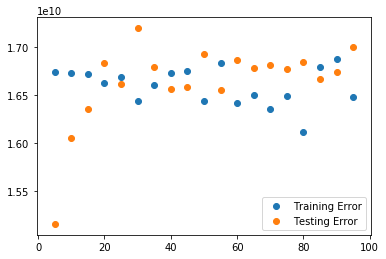

In [126]:
import random
random.seed(11)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))

plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

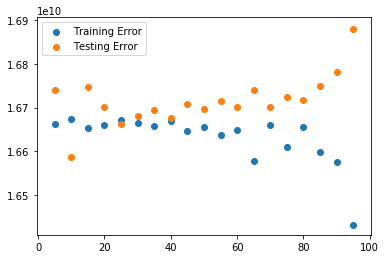

In [127]:
random.seed(8)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

In [128]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='neg_mean_squared_error'))

# Train-test split 

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [130]:
# A brief preview of train-test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

15515 3879 15515 3879


# Fit the model

In [131]:
linreg = LinearRegression()

linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)

# Residuals and MSE

In [132]:
test_residuals = y_hat_test - y_test

test_mse = mean_squared_error(y_test, y_hat_test)
test_mse

16314450214.864172